<a href="https://colab.research.google.com/github/jonnunez92/Stroke-Prediction/blob/main/Healthcare_Stroke_Prediction_Jonathan_Nunez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Healthcare Stroke Prediction**

Jonathan Nunez

# Load Data and Libraries


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline

## Models
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sampler_pipeline
from xgboost import XGBClassifier
from sklearn.decomposition import PCA

## Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

## Set global scikit-learn configuration
from sklearn import set_config
## Display estimators as a diagram
set_config(display='diagram')  # 'text' or 'diagram'}

import warnings
warnings.filterwarnings('ignore')

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
df_original = pd.read_csv('/content/drive/MyDrive/Kaggle/healthcare-dataset-stroke-data.csv')
df = df_original.copy()
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [11]:
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

# Clean Data

## Data types and Info

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [13]:
# object datatypes
df.dtypes[df.dtypes == 'object']

gender            object
ever_married      object
work_type         object
Residence_type    object
smoking_status    object
dtype: object

In [14]:
# number datatypes
df.dtypes[df.dtypes != 'object']

id                     int64
age                  float64
hypertension           int64
heart_disease          int64
avg_glucose_level    float64
bmi                  float64
stroke                 int64
dtype: object

## Duplicates

In [15]:
df.duplicated().sum()

0

## Inconsistencies in 'object' Categories

In [16]:
for i in df.dtypes[df.dtypes == 'object'].index:
    print(f'{i} ---')
    print(df[i].value_counts())
    print('')

gender ---
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

ever_married ---
Yes    3353
No     1757
Name: ever_married, dtype: int64

work_type ---
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

Residence_type ---
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

smoking_status ---
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64



### Remove 'Other' in 'gender' Column

- Only 1 'Other' in 'gender' column
    - Statistically insignificant, can be removed

In [17]:
df[df['gender'] == 'Other']
df.drop(index=3116, inplace=True)
df[df['gender'] == 'Other']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


### 'smoking_status' replace 'Unknown' with 'smokes'

- Will replace the 'Unknown' values with 'smokes' since it would seem to be the case that people who feel guilty about smoking would refuse to answer
    - Otherwise, they would answer that they never or formerly smoked

In [18]:
#df['smoking_status'] = df['smoking_status'].replace('Unknown', 'smokes')

for i in df.dtypes[df.dtypes == 'object'].index:
    print(f'{i} ---')
    print(df[i].unique())
    print('')

gender ---
['Male' 'Female']

ever_married ---
['Yes' 'No']

work_type ---
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']

Residence_type ---
['Urban' 'Rural']

smoking_status ---
['formerly smoked' 'never smoked' 'smokes' 'Unknown']



## Inconsistencies in 'number' Categories

In [19]:
df.describe(include='number')

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,4908.00000,5109.000000
mean,36513.985516,43.229986,0.097475,0.054022,106.140399,28.89456,0.048738
std,21162.008804,22.613575,0.296633,0.226084,45.285004,7.85432,0.215340
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.30000,0.000000
25%,17740.000000,25.000000,0.000000,0.000000,77.240000,23.50000,0.000000
50%,36922.000000,45.000000,0.000000,0.000000,91.880000,28.10000,0.000000
75%,54643.000000,61.000000,0.000000,0.000000,114.090000,33.10000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.60000,1.000000


- 'age' shows **min** age of *0.08*
- 'bmi' shows **max** bmi of *97.6*
- Notable values that I'll keep in mind

### Investigate Notable Values

In [20]:
# age of 0.08
df[df['age'] == 0.08]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1614,47350,Female,0.08,0,0,No,children,Urban,139.67,14.1,Unknown,0
3295,29955,Male,0.08,0,0,No,children,Rural,70.33,16.9,Unknown,0


- Only 2 samples, correctly attributed as 'children'
    - Will keep

In [21]:
# bmi of 97.6
df[df['bmi'] == 97.6]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2128,56420,Male,17.0,1,0,No,Private,Rural,61.67,97.6,Unknown,0


- Only 1 sample, 17 year old male with hypertension, but no heart disease
    - This is a Negative target value, so it can be removed

In [22]:
df.drop(index=2128, inplace=True)
df[df['bmi'] == 97.6]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


## Missing Data

In [23]:
# missing values as percentage
round((df.isna().sum() / len(df)) * 100, 2)

id                   0.00
gender               0.00
age                  0.00
hypertension         0.00
heart_disease        0.00
ever_married         0.00
work_type            0.00
Residence_type       0.00
avg_glucose_level    0.00
bmi                  3.94
smoking_status       0.00
stroke               0.00
dtype: float64

- Since the missing 'bmi' data accounts for only 3.94% of data, I will remove these missing rows

In [24]:
df.dropna(axis=0, subset='bmi', inplace=True)
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4907 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4907 non-null   int64  
 1   gender             4907 non-null   object 
 2   age                4907 non-null   float64
 3   hypertension       4907 non-null   int64  
 4   heart_disease      4907 non-null   int64  
 5   ever_married       4907 non-null   object 
 6   work_type          4907 non-null   object 
 7   Residence_type     4907 non-null   object 
 8   avg_glucose_level  4907 non-null   float64
 9   bmi                4907 non-null   float64
 10  smoking_status     4907 non-null   object 
 11  stroke             4907 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 498.4+ KB


## Remove Unnecessary/ Irrelevant Columns

### Drop 'id'
- Too unique and not necessary for predicting strokes

In [26]:
df.drop(columns='id', inplace=True)

In [27]:
df.head(1)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1


In [28]:
df['stroke'].value_counts()

0    4698
1     209
Name: stroke, dtype: int64

# Exploratory Visualizations

## Count of Smoking Status with Stroke Count

In [30]:
df['smoking_status'].value_counts()

never smoked       1852
Unknown            1482
formerly smoked     836
smokes              737
Name: smoking_status, dtype: int64

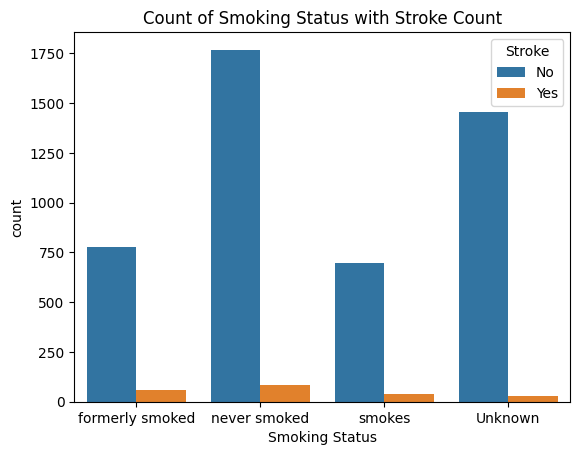

In [34]:
fig, ax = plt.subplots()

ax = sns.countplot(data=df, x='smoking_status', hue='stroke')
ax.set_title('Count of Smoking Status with Stroke Count')
ax.set_xlabel('Smoking Status')
plt.legend(title='Stroke', labels=['No', 'Yes']);

- There are much more people that *don't* have strokes
- We can see that there are a significant amount of smokers
  - That being said, their rate of stroke is about the same as non-smokers

## Count of Gender with Stroke Count

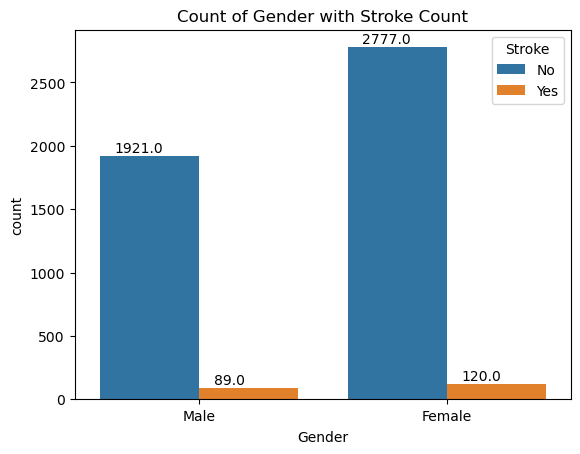

In [ ]:
fig, ax = plt.subplots()

ax = sns.countplot(data=df, x='gender', hue='stroke')

ax.set_title('Count of Gender with Stroke Count')
ax.set_xlabel('Gender')
plt.legend(title='Stroke', labels=['No', 'Yes'])
ax.xaxis.labelpad = 5

# code below was found on StackOverflow
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()),
                (p.get_x() + 0.06, p.get_height() + 30))

- We can see that there are more females represented in this dataset
- More females *don't* have strokes, but at the same time, more females *do* have strokes

## Distribution of Numeric Columns

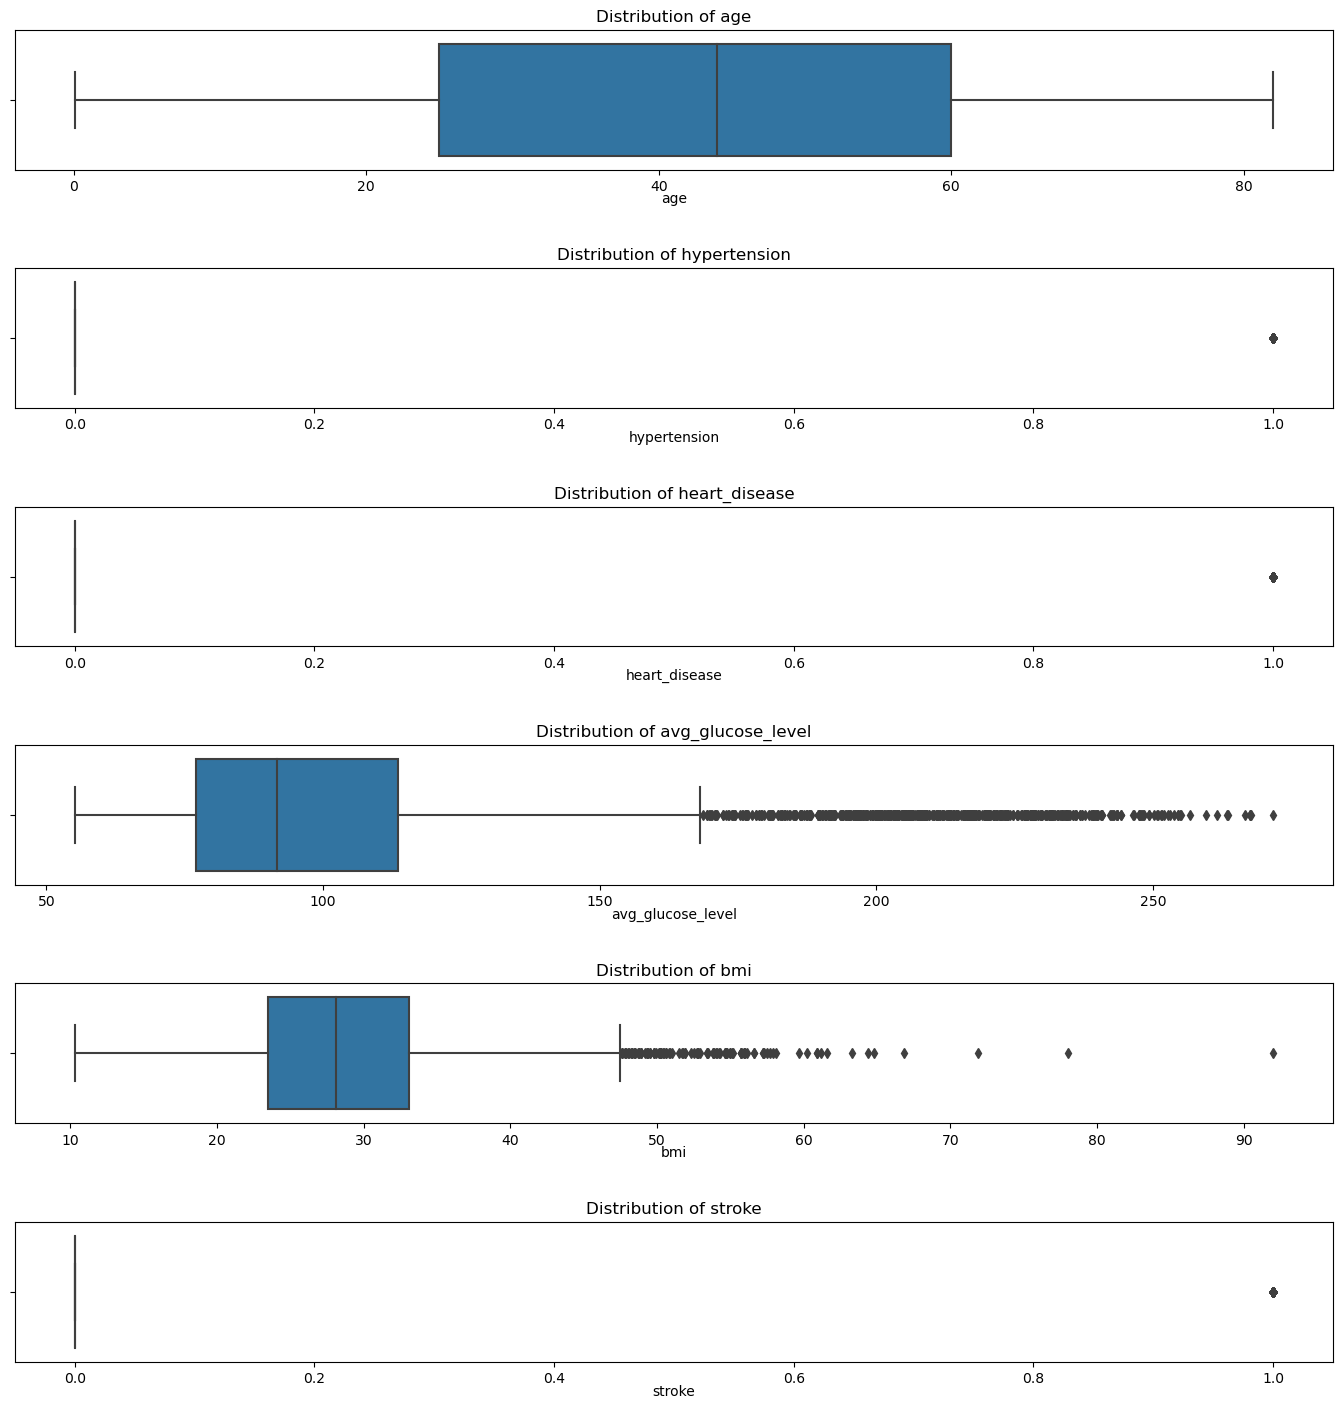

In [ ]:
fig, axes = plt.subplots(nrows=6, figsize=(15, 15))
fig.tight_layout(pad=5)

for i, column in enumerate(df.dtypes[df.dtypes != 'object'].index):
    sns.boxplot(data=df, x=column, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].xaxis.labelpad = -1

- Median age is around 40
- Median BMI is around 30
- BMI had a lot of outliers which were removed
- Median glucose level is around 90
    - There were a significant amount of outliers for 'avg_glucose_level' that were removed
- 'hypertension', 'heart_disease', and 'stroke' are all binary values so won't visualize properly, since all values are either 0 or 1

In [ ]:
df.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

# Explanatory Visualizations

In [ ]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


## Heatmap

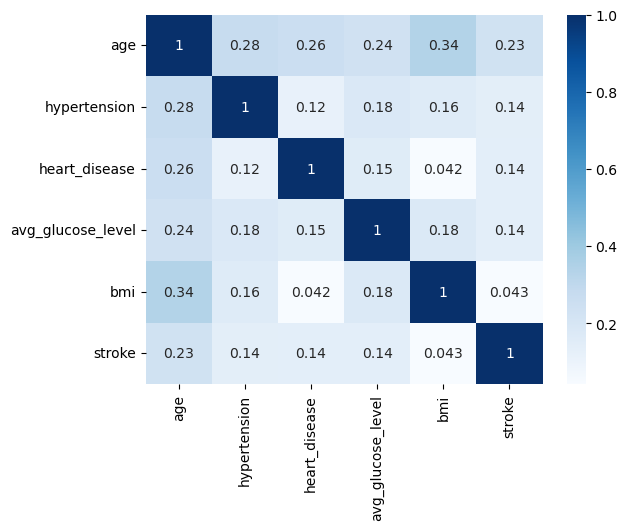

In [ ]:
corr = df.corr()
sns.heatmap(data=corr, cmap='Blues', annot=True);

- Looks like the feature most correlated with 'stroke' is 'age'
- 'avg_glucose_level' and 'bmi' are very much not correlated with 'stroke'
- It seems that 'age' is correlated with most of the other features and is an indicator of negative health aspects

## Bargraph Stroke by Age

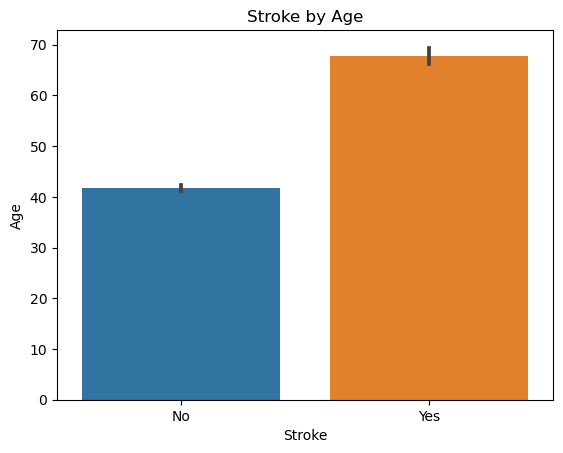

In [ ]:
fig, ax = plt.subplots()

sns.barplot(data=df, x='stroke', y='age')
ax.set_title('Stroke by Age')
ax.set_xlabel('Stroke')
ax.set_ylabel('Age')
plt.xticks(range(0, 2), ['No', 'Yes']);

- People that get strokes are, on average, older; around 65-70 years old
- People that don't get strokes are, on average, younger at around 40 years old

## Lineplot Age by BMI

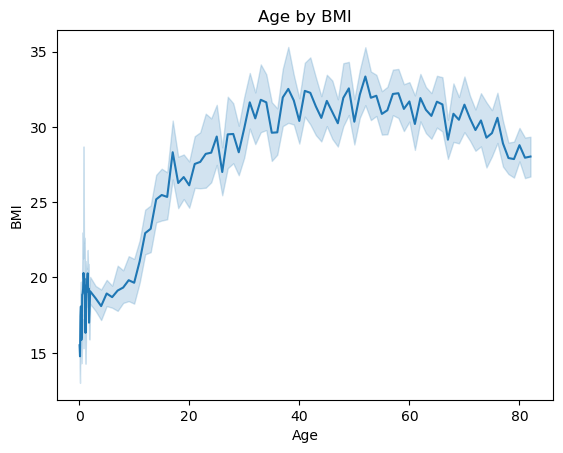

In [ ]:
ax = sns.lineplot(data=df, x='age', y='bmi')
ax.set_title('Age by BMI')
ax.set_xlabel('Age')
ax.set_ylabel('BMI');

- As Age increases so does BMI
- Does seem to plateau a bit at around 30 BMI

## Bargraph Age by Hypertension with Heart Disease

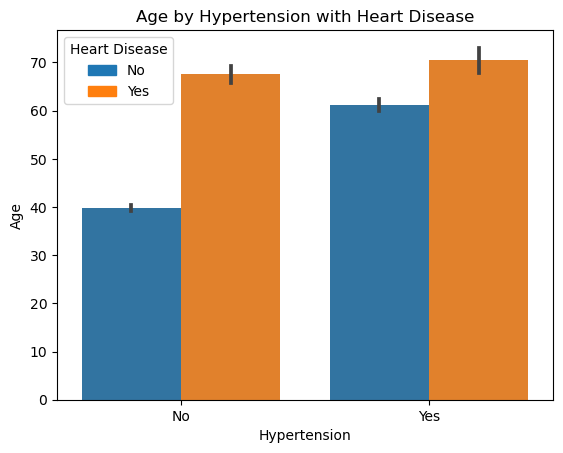

In [ ]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots()

ax = sns.barplot(data=df, x='hypertension', y='age', hue='heart_disease')
ax.set_title('Age by Hypertension with Heart Disease')
ax.set_xlabel('Hypertension')
ax.set_ylabel('Age')
plt.xticks(range(0,2), ['No', 'Yes'])

blue_patch = mpatches.Patch(color='tab:blue', label='No')
orange_patch = mpatches.Patch(color='tab:orange', label='Yes')

ax.legend(handles=[blue_patch, orange_patch], title='Heart Disease')

plt.show()

- If you have Hypertension you are usually older, around 60-70
- If you have Heart Disease, you are most likely around 65 years old, but may or may not have Hypertension
- If you have no Hypertension and no Heart Disease, you are around 38 years old

## Age by Average Glucose Level

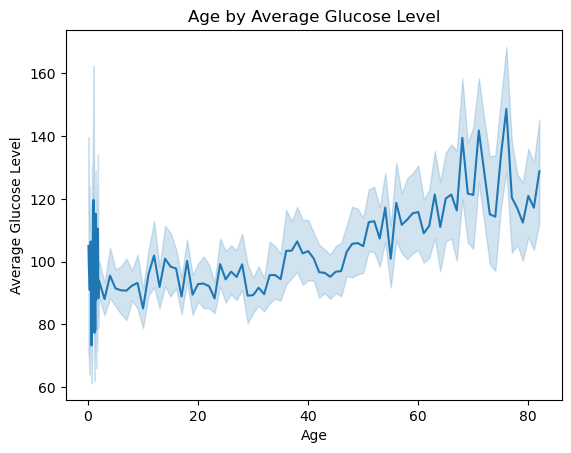

In [ ]:
ax = sns.lineplot(data=df, x='age', y='avg_glucose_level')
ax.set_title('Age by Average Glucose Level')
ax.set_xlabel('Age')
ax.set_ylabel('Average Glucose Level');

- 'age' seems to be correlated with all other features except 'avg_glucose_level
    - This feature doesn't seem to be correlated with any other feature; it stands alone

## Reporting for Two Visualizations

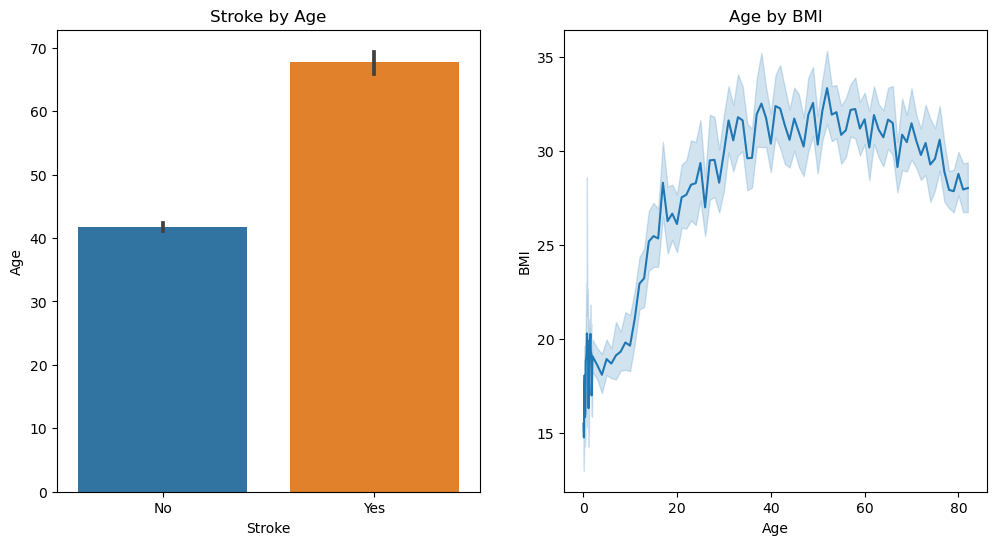

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12,6))

sns.barplot(data=df, x='stroke', y='age', ax=axes[0])
axes[0].set_title('Stroke by Age')
axes[0].set_xlabel('Stroke')
axes[0].set_ylabel('Age')
axes[0].set_xticks(range(0, 2), ['No', 'Yes'])

sns.lineplot(data=df, x='age', y='bmi', ax=axes[1])
axes[1].set_title('Age by BMI')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('BMI');

**Stroke by Age**

- People that get strokes are, on average, older; around 65-70 years old
- People that don't get strokes are, on average, younger at around 40 years old
- Out of all the features in this dataset, Stroke is mostly correlated with Age

**Age by BMI**
- As Age increases so does BMI
- Does seem to plateau a bit at around 30 BMI
- Age is interesting as it is correlated with every other feature except one ('avg_glucose_level', which doesn't correlate with anything) and is mostly correlated with BMI

# Machine Learning

## Custom Classification Function

In [ ]:
## Create a function to display the classification metrics of a model
def probability_report_matrix(model, X_test, y_test, label='Probability Test Data', 
                             figsize=(15,5), normalize=None,
                             cmap='Greens', thresh=.5): 
                             
    fig, axes = plt.subplots(1,2, figsize=figsize)

    ## Get the predictions
    y_proba = model.predict_proba(X_test)
    y_pred = [1 if x[1] > thresh else 0 for x in y_proba]
    
    ## Print classification report for the test data (and make it pretty!)
    print('---'*20)
    print(f"[i] CLASSIFICATION REPORT FOR: {label}")
    print('---'*20)

    print(classification_report(y_test, y_pred))

    ConfusionMatrixDisplay.from_predictions(y_test,y_pred, 
                normalize=normalize, cmap=cmap,              
                ax=axes[0])    
    
    RocCurveDisplay.from_estimator(model, X_test, y_test,
                                   ax=axes[1])
    print('This code was taken from Coding Dojo Code Along')
    plt.show()

## Preprocessing

In [ ]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


### Tranformers, Pipelines, Column Selectors

In [ ]:
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

num_tuple = (scaler, num_selector)
cat_tuple = (ohe, cat_selector)

preprocessor = make_column_transformer(num_tuple, cat_tuple, remainder='drop')
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127310>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127BB0>)])

- There is no missing data, cleaning was done above

## Split Validation

In [ ]:
df['stroke'].value_counts(normalize=True)

0    0.957408
1    0.042592
Name: stroke, dtype: float64

- Target column is very imbalanced, will need to stratify and increase the test size

In [ ]:
X = df.drop(columns='stroke')
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

## KNN Model

In [ ]:
knn = KNeighborsClassifier()

knn_pipe = make_pipeline(preprocessor, knn)
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127310>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127BB0>)])),
                ('kneighborsclassifier', KNeighborsClassifier())])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: KNN Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3288
           1       0.50      0.03      0.06       146

    accuracy                           0.96      3434
   macro avg       0.73      0.52      0.52      3434
weighted avg       0.94      0.96      0.94      3434

This code was taken from Coding Dojo Code Along


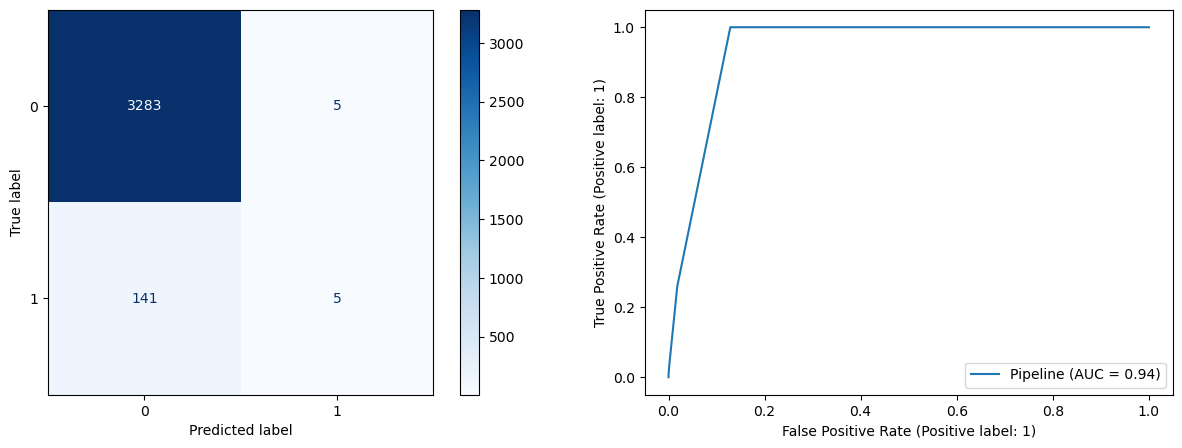

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: KNN Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1410
           1       0.00      0.00      0.00        63

    accuracy                           0.96      1473
   macro avg       0.48      0.50      0.49      1473
weighted avg       0.92      0.96      0.94      1473

This code was taken from Coding Dojo Code Along


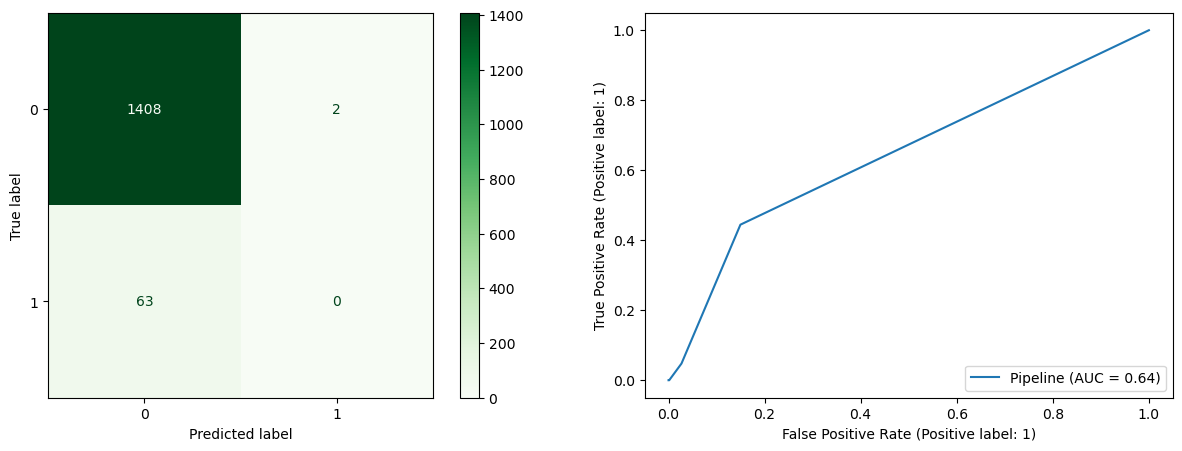

In [ ]:
probability_report_matrix(knn_pipe, X_train, y_train, label='KNN Train Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Blues', thresh=.5)

probability_report_matrix(knn_pipe, X_test, y_test, label='KNN Test Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Greens', thresh=.5)

### KNN Tuning

In [ ]:
knn_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127310>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127BB0>)])),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127310>),
                                 ('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                   

In [ ]:
param_grid = {'kneighborsclassifier__n_neighbors': range(1,10),
              'kneighborsclassifier__p': range(1,5),
              'kneighborsclassifier__weights': ['distance','uniform']}

In [ ]:
knn_pipe_gs = GridSearchCV(knn_pipe, param_grid, scoring='f1')
 
knn_pipe_gs.fit(X_train, y_train)
print('Best KNN Parameters:')
print(knn_pipe_gs.best_params_)
best_pipe = knn_pipe_gs.best_estimator_
print(f'Accuracy of best KNN model is: {best_pipe.score(X_test, y_test)}')

Best KNN Parameters:
{'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__p': 3, 'kneighborsclassifier__weights': 'distance'}
Accuracy of best KNN model is: 0.924643584521385


### Tuned KNN

In [ ]:
tuned_knn = KNeighborsClassifier(n_neighbors=1, p=4, weights='distance')
tuned_knn_pipe = make_pipeline(preprocessor, tuned_knn)
tuned_knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127310>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127BB0>)])),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=1, p=4, weights='distance'))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Tuned KNN Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3288
           1       1.00      1.00      1.00       146

    accuracy                           1.00      3434
   macro avg       1.00      1.00      1.00      3434
weighted avg       1.00      1.00      1.00      3434

This code was taken from Coding Dojo Code Along


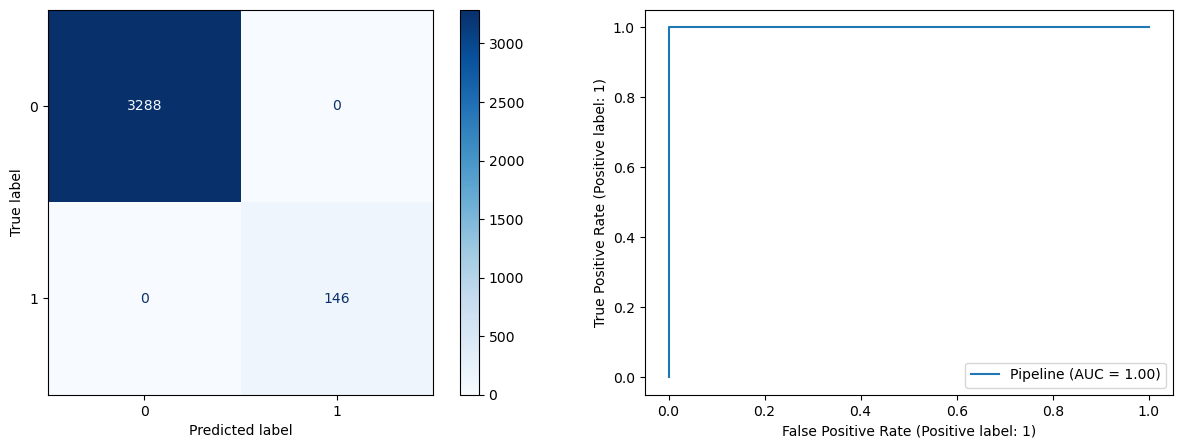

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Tuned KNN Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1410
           1       0.09      0.08      0.08        63

    accuracy                           0.93      1473
   macro avg       0.53      0.52      0.52      1473
weighted avg       0.92      0.93      0.92      1473

This code was taken from Coding Dojo Code Along


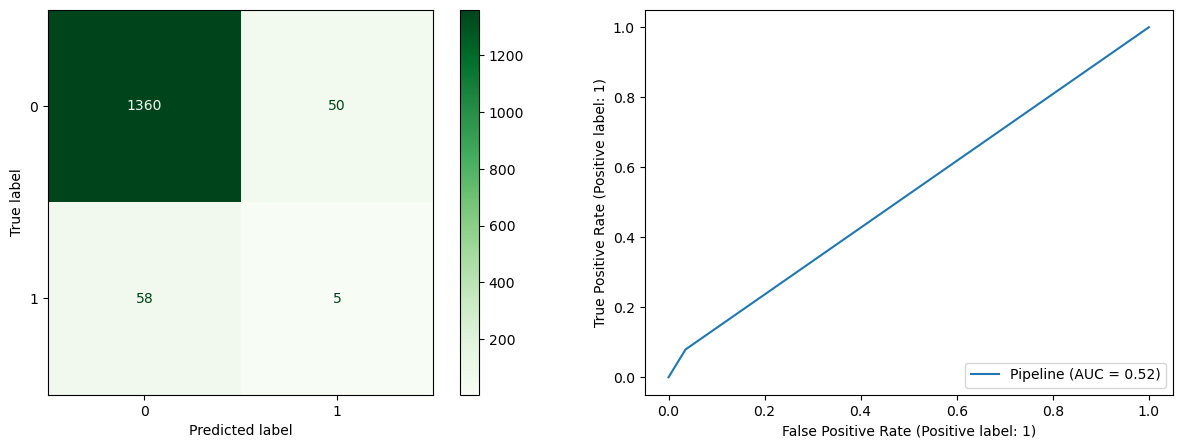

In [ ]:
probability_report_matrix(tuned_knn_pipe, X_train, y_train, label='Tuned KNN Train Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Blues', thresh=.5)

probability_report_matrix(tuned_knn_pipe, X_test, y_test, label='Tuned KNN Test Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Greens', thresh=.3)

### Under Sampling KNN

In [ ]:
under_sampler = RandomUnderSampler()
knn = KNeighborsClassifier()
under_knn_pipe = make_sampler_pipeline(preprocessor, under_sampler, knn)
#Fit and evaluate the model pipeline
under_knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127310>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127BB0>)])),
                ('randomundersampler', RandomUnderSampler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Under Sampling KNN Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.72      0.83      3288
           1       0.12      0.84      0.21       146

    accuracy                           0.72      3434
   macro avg       0.55      0.78      0.52      3434
weighted avg       0.95      0.72      0.81      3434

This code was taken from Coding Dojo Code Along


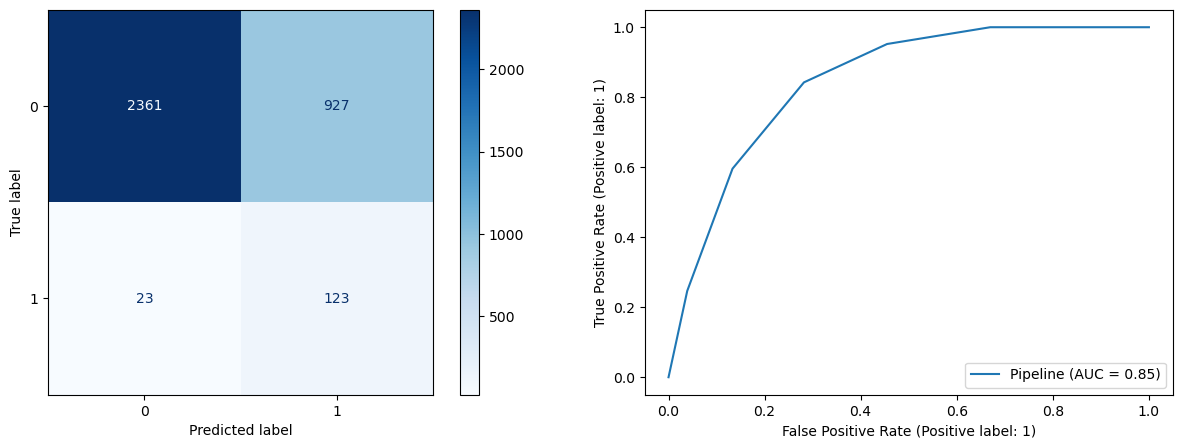

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Under Sampling KNN Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.71      0.82      1410
           1       0.09      0.68      0.17        63

    accuracy                           0.71      1473
   macro avg       0.54      0.70      0.49      1473
weighted avg       0.94      0.71      0.79      1473

This code was taken from Coding Dojo Code Along


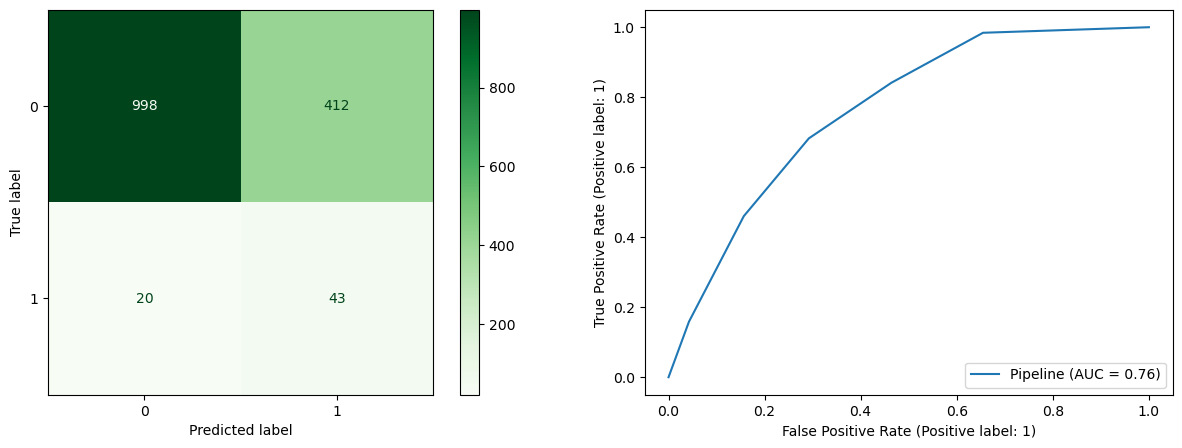

In [ ]:
probability_report_matrix(under_knn_pipe, X_train, y_train, label='Under Sampling KNN Train Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Blues', thresh=.5)

probability_report_matrix(under_knn_pipe, X_test, y_test, label='Under Sampling KNN Test Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Greens', thresh=.5)

### Tuned Under Sampling KNN

In [ ]:
under_knn_pipe_gs = GridSearchCV(under_knn_pipe, param_grid, scoring='f1')
 
under_knn_pipe_gs.fit(X_train, y_train)
print('Best KNN Parameters:')
print(under_knn_pipe_gs.best_params_)
best_under_knn_pipe = under_knn_pipe_gs.best_estimator_
print(f'Accuracy of best KNN model is: {best_under_knn_pipe.score(X_test, y_test)}')

Best KNN Parameters:
{'kneighborsclassifier__n_neighbors': 6, 'kneighborsclassifier__p': 3, 'kneighborsclassifier__weights': 'uniform'}
Accuracy of best KNN model is: 0.7175831636116768


In [ ]:
tuned_under_knn = KNeighborsClassifier(n_neighbors=6, p=3, weights='uniform')
tuned_under_knn_pipe = make_sampler_pipeline(preprocessor, under_sampler, tuned_under_knn)
#Fit and evaluate the model pipeline
tuned_under_knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127310>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127BB0>)])),
                ('randomundersampler', RandomUnderSampler()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=6, p=3))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Tuned Under Sampling KNN Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      3288
           1       0.14      0.77      0.24       146

    accuracy                           0.79      3434
   macro avg       0.56      0.78      0.56      3434
weighted avg       0.95      0.79      0.85      3434

This code was taken from Coding Dojo Code Along


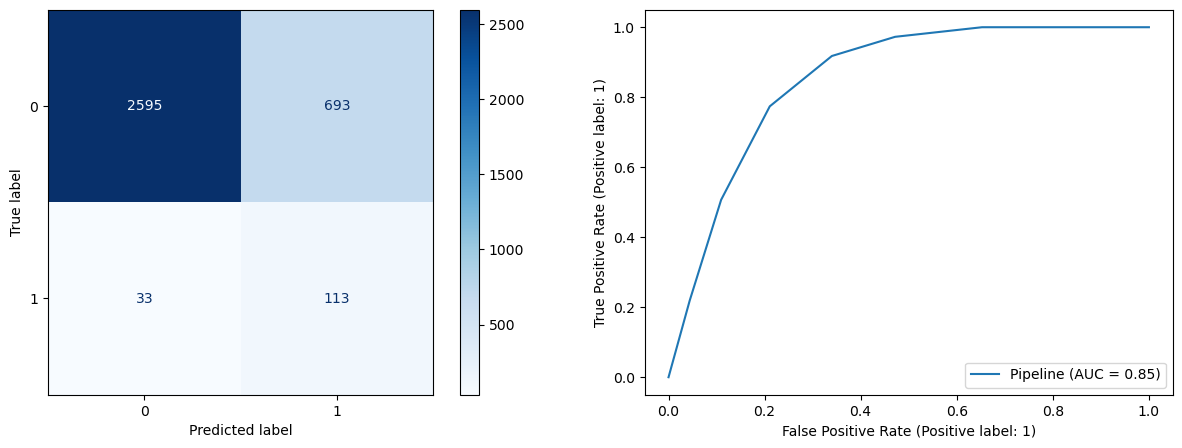

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Tuned Under Sampling KNN Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.77      0.86      1410
           1       0.11      0.62      0.18        63

    accuracy                           0.76      1473
   macro avg       0.54      0.69      0.52      1473
weighted avg       0.94      0.76      0.83      1473

This code was taken from Coding Dojo Code Along


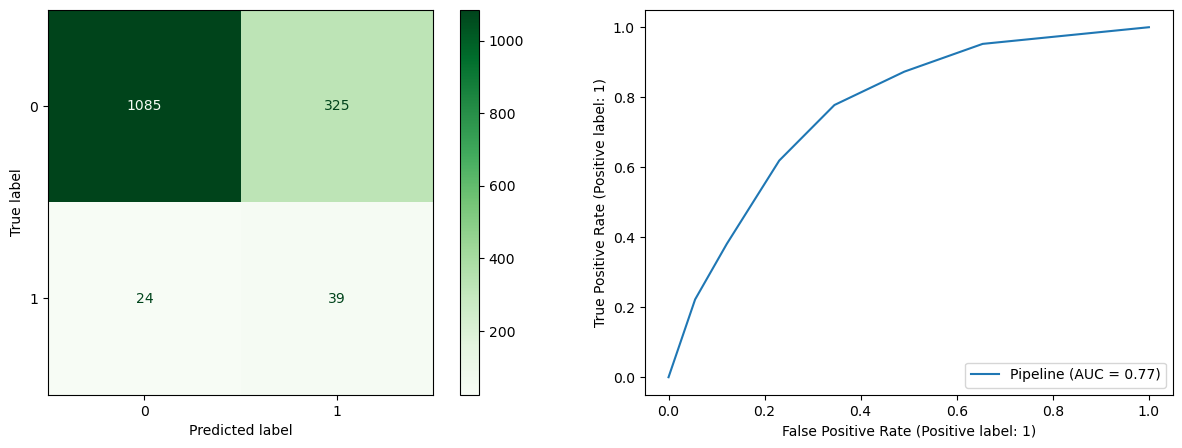

In [ ]:
probability_report_matrix(tuned_under_knn_pipe, X_train, y_train, label='Tuned Under Sampling KNN Train Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Blues', thresh=.5)

probability_report_matrix(tuned_under_knn_pipe, X_test, y_test, label='Tuned Under Sampling KNN Test Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Greens', thresh=.5)

## Random Forest Model

In [ ]:
rf = RandomForestClassifier(random_state=42)

rf_pipe = make_pipeline(preprocessor, rf)
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127310>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127BB0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Random Forest Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3288
           1       1.00      1.00      1.00       146

    accuracy                           1.00      3434
   macro avg       1.00      1.00      1.00      3434
weighted avg       1.00      1.00      1.00      3434

This code was taken from Coding Dojo Code Along


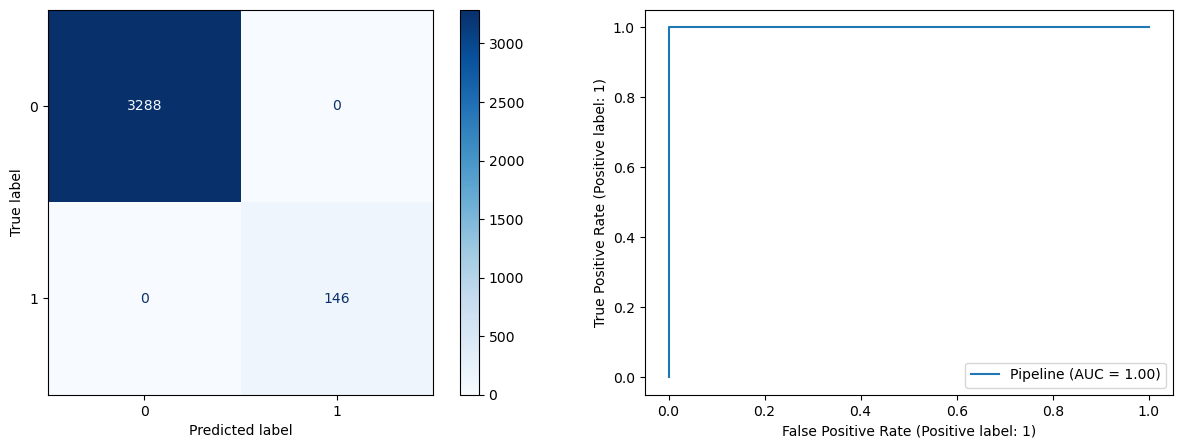

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Random Forest Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1410
           1       0.00      0.00      0.00        63

    accuracy                           0.96      1473
   macro avg       0.48      0.50      0.49      1473
weighted avg       0.92      0.96      0.94      1473

This code was taken from Coding Dojo Code Along


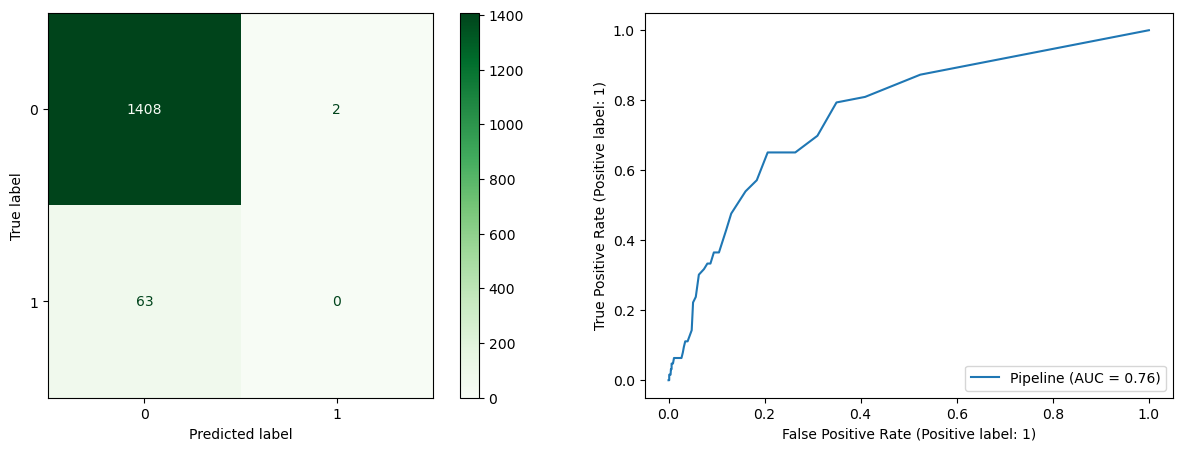

In [ ]:
probability_report_matrix(rf_pipe, X_train, y_train, label='Random Forest Train Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Blues', thresh=.5)

probability_report_matrix(rf_pipe, X_test, y_test, label='Random Forest Test Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Greens', thresh=.5)

### Random Forest Tuning

In [ ]:
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127310>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127BB0>)])),
  ('randomforestclassifier', RandomForestClassifier(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127310>),
                                 ('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',


In [ ]:
rf_params = {'randomforestclassifier__class_weight': [None, 'balanced', 'balanced_subsample'],
            'randomforestclassifier__max_depth': [None, 5, 10, 15],
            'randomforestclassifier__n_estimators': [10, 30, 50, 100],
            'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss']}

In [ ]:
rf_pipe_gs = GridSearchCV(rf_pipe, rf_params, scoring='f1')
 
rf_pipe_gs.fit(X_train, y_train)
print('Best Random Forest Parameters:')
print(rf_pipe_gs.best_params_)
best_rf_pipe = rf_pipe_gs.best_estimator_
print(f'Accuracy of best Random Forest model is: {best_rf_pipe.score(X_test, y_test)}')

Best Random Forest Parameters:
{'randomforestclassifier__class_weight': 'balanced_subsample', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 100}
Accuracy of best Random Forest model is: 0.7311608961303462


### Tuned Random Forest Model

In [ ]:
tuned_rf = RandomForestClassifier(class_weight='balanced_subsample', max_depth=5, n_estimators=100, random_state=42)

tuned_rf_pipe = make_pipeline(preprocessor, tuned_rf)
tuned_rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127310>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127BB0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=5, random_state=42))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Tuned Random Forest Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.76      0.86      3288
           1       0.14      0.89      0.25       146

    accuracy                           0.77      3434
   macro avg       0.57      0.83      0.55      3434
weighted avg       0.96      0.77      0.84      3434

This code was taken from Coding Dojo Code Along


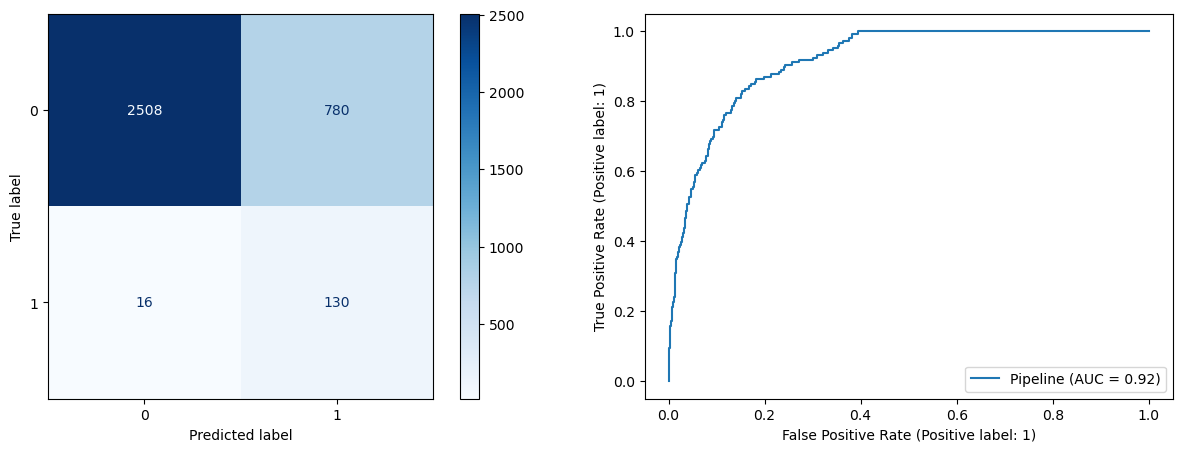

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Tuned Random Forest Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.73      0.84      1410
           1       0.10      0.68      0.18        63

    accuracy                           0.73      1473
   macro avg       0.54      0.71      0.51      1473
weighted avg       0.94      0.73      0.81      1473

This code was taken from Coding Dojo Code Along


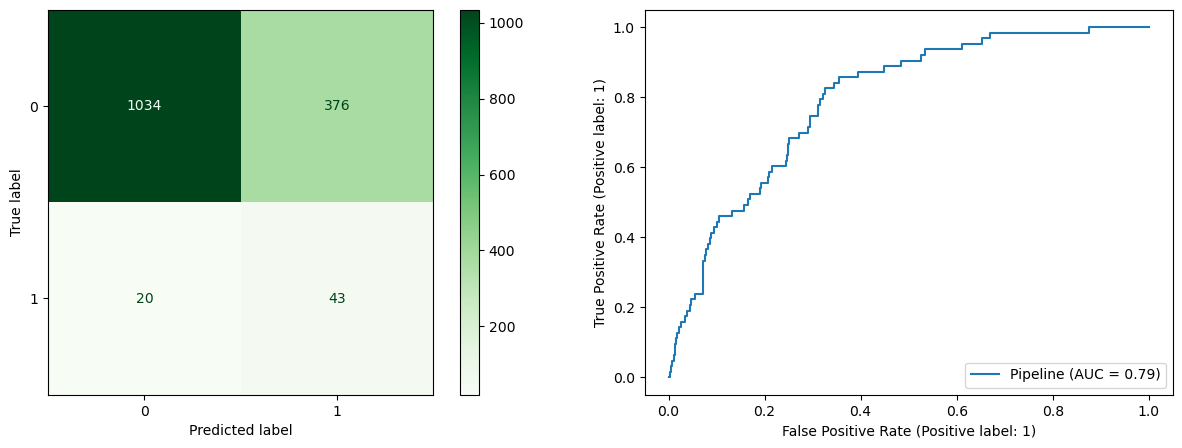

In [ ]:
probability_report_matrix(tuned_rf_pipe, X_train, y_train, label='Tuned Random Forest Train Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Blues', thresh=.5)

probability_report_matrix(tuned_rf_pipe, X_test, y_test, label='Tuned Random Forest Test Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Greens', thresh=.5)

### Under Sampling Random Forest

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

under_sampler = RandomUnderSampler()

under_rf_pipe = make_sampler_pipeline(preprocessor, under_sampler, rf)
under_rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127310>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127BB0>)])),
                ('randomundersampler', RandomUnderSampler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Under Sampling Random Forest Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.71      0.83      3288
           1       0.13      1.00      0.24       146

    accuracy                           0.73      3434
   macro avg       0.57      0.86      0.53      3434
weighted avg       0.96      0.73      0.81      3434

This code was taken from Coding Dojo Code Along


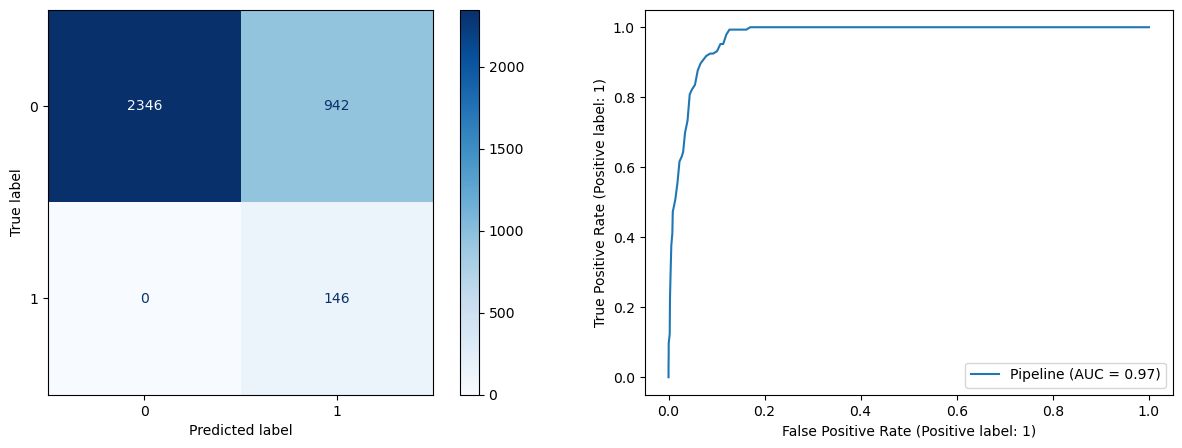

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Under Sampling Random Forest Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.69      0.81      1410
           1       0.10      0.75      0.17        63

    accuracy                           0.69      1473
   macro avg       0.54      0.72      0.49      1473
weighted avg       0.95      0.69      0.79      1473

This code was taken from Coding Dojo Code Along


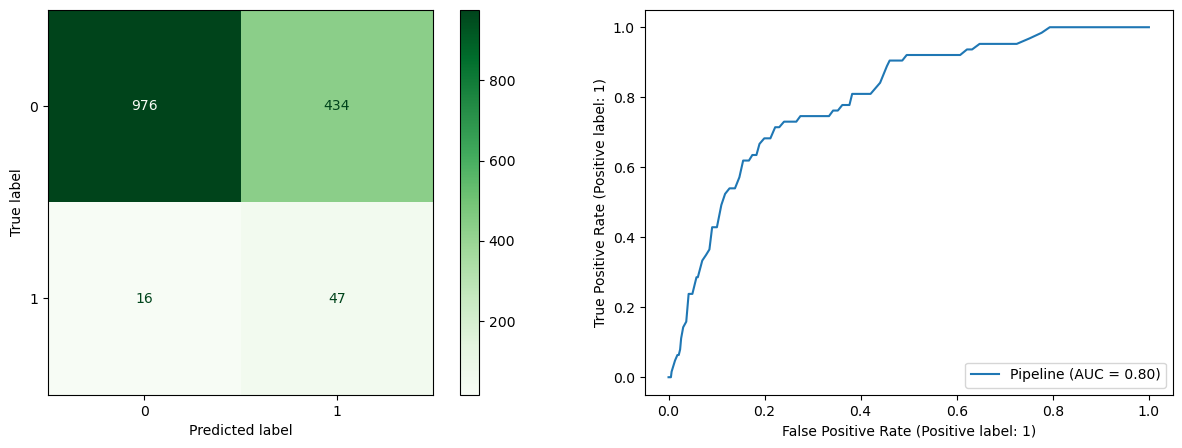

In [ ]:
probability_report_matrix(under_rf_pipe, X_train, y_train, label='Under Sampling Random Forest Train Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Blues', thresh=.5)

probability_report_matrix(under_rf_pipe, X_test, y_test, label='Under Sampling Random Forest Test Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Greens', thresh=.5)

### Tuned Under Sampling Random Forest

In [ ]:
under_rf_pipe_gs = GridSearchCV(under_rf_pipe, rf_params)
 
under_rf_pipe_gs.fit(X_train, y_train)
print('Best Random Forest Parameters:')
print(under_rf_pipe_gs.best_params_)
best_under_rf_pipe = under_rf_pipe_gs.best_estimator_
print(f'Accuracy of best Random Forest model is: {best_under_rf_pipe.score(X_test, y_test)}')

Best Random Forest Parameters:
{'randomforestclassifier__class_weight': 'balanced_subsample', 'randomforestclassifier__criterion': 'log_loss', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 10}
Accuracy of best Random Forest model is: 0.7304820095044128


In [ ]:
tuned_under_rf = RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                                        max_depth=None, n_estimators=10, random_state=42)

tuned_under_rf_pipe = make_sampler_pipeline(preprocessor, under_sampler, tuned_under_rf)
tuned_under_rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127310>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127BB0>)])),
                ('randomundersampler', RandomUnderSampler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        criterion='log_loss', n_estimators=10,
                                        random_state=42))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Tuned Under Sampling Random Forest Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.75      0.86      3288
           1       0.15      0.97      0.25       146

    accuracy                           0.76      3434
   macro avg       0.57      0.86      0.56      3434
weighted avg       0.96      0.76      0.83      3434

This code was taken from Coding Dojo Code Along


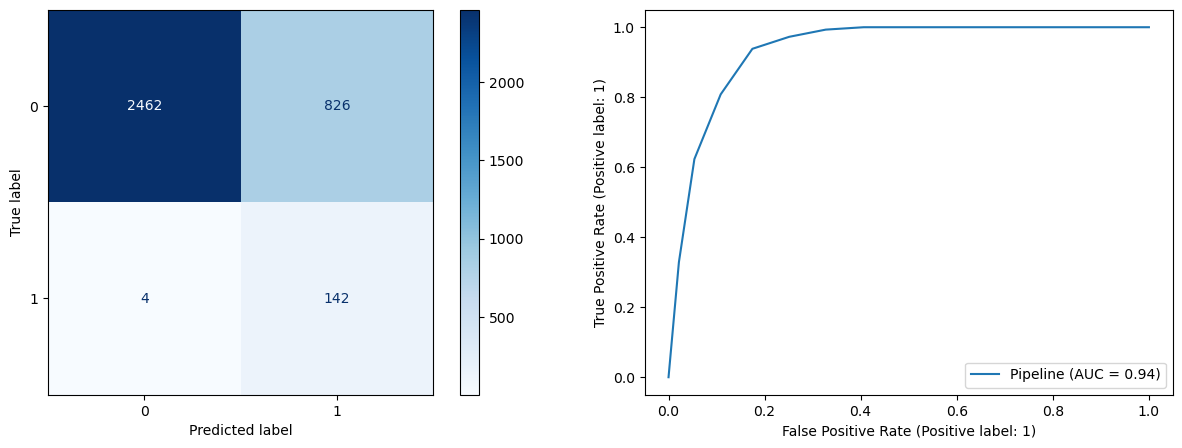

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Tuned Under Sampling Random Forest Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.73      0.84      1410
           1       0.10      0.65      0.17        63

    accuracy                           0.73      1473
   macro avg       0.54      0.69      0.50      1473
weighted avg       0.94      0.73      0.81      1473

This code was taken from Coding Dojo Code Along


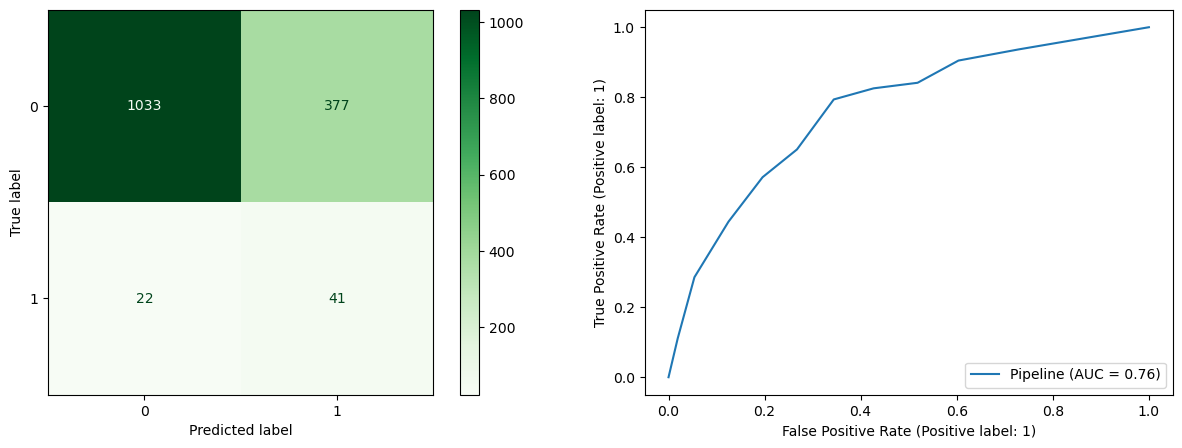

In [ ]:
probability_report_matrix(tuned_under_rf_pipe, X_train, y_train, label='Tuned Under Sampling Random Forest Train Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Blues', thresh=.5)

probability_report_matrix(tuned_under_rf_pipe, X_test, y_test, label='Tuned Under Sampling Random Forest Test Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Greens', thresh=.5)

## XGBoost Model

In [ ]:
xgb = XGBClassifier(random_state=42, verbosity=0)

xgb_pipe = make_pipeline(preprocessor, xgb)
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127310>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127BB0>)])),
                ('...
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=16, num_parallel_tree=1, predictor='auto',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=0))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: XGBoost Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3288
           1       1.00      0.99      0.99       146

    accuracy                           1.00      3434
   macro avg       1.00      0.99      1.00      3434
weighted avg       1.00      1.00      1.00      3434

This code was taken from Coding Dojo Code Along


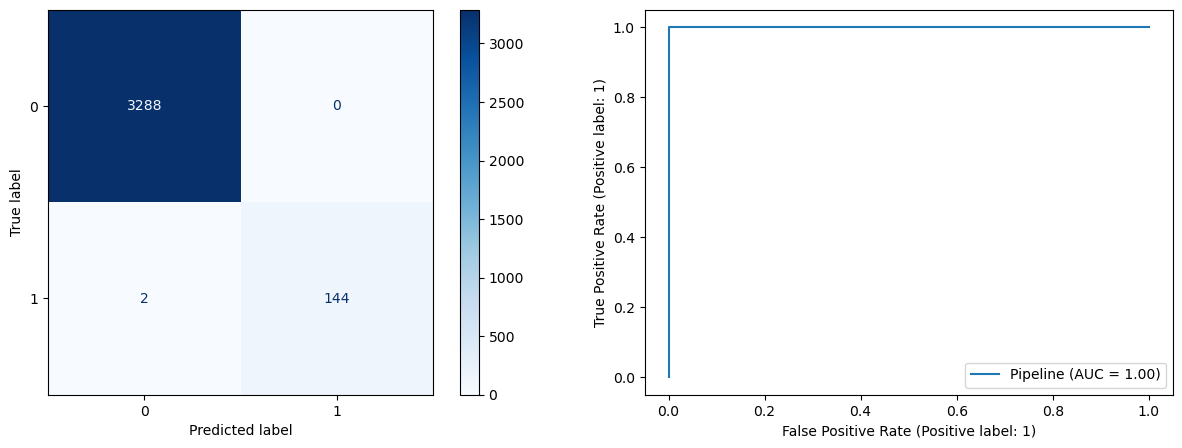

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: XGBoost Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1410
           1       0.17      0.05      0.07        63

    accuracy                           0.95      1473
   macro avg       0.56      0.52      0.52      1473
weighted avg       0.92      0.95      0.94      1473

This code was taken from Coding Dojo Code Along


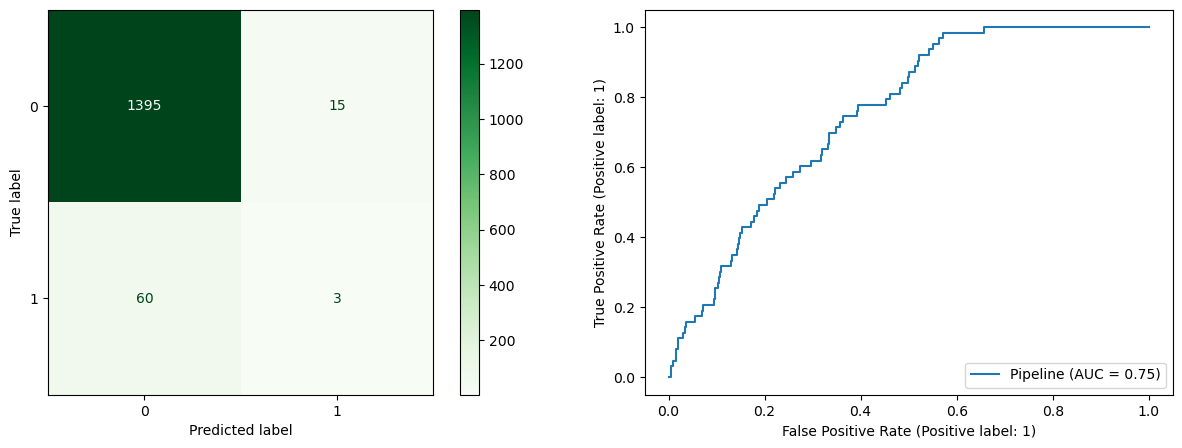

In [ ]:
probability_report_matrix(xgb_pipe, X_train, y_train, label='XGBoost Train Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Blues', thresh=.5)

probability_report_matrix(xgb_pipe, X_test, y_test, label='XGBoost Test Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Greens', thresh=.5)

### XGBoost Tuning

In [ ]:
xgb_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127310>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127BB0>)])),
  ('xgbclassifier',
   XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
                 gamma=0, gpu_id=-1, importance_type=None,
                 interaction_constraints='', learning_rate=0.300000012,
                 max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
                 monotone_constraints='()',

In [ ]:
y.value_counts()

0    4698
1     209
Name: stroke, dtype: int64

In [ ]:
xgb_params = {'xgbclassifier__max_delta_step': range(0,6),
             'xgbclassifier__max_depth': range(3,11),
             'xgbclassifier__n_estimators': [10, 30, 50, 100]}

In [ ]:
xgb_pipe_gs = GridSearchCV(xgb_pipe, xgb_params, scoring='f1')
 
xgb_pipe_gs.fit(X_train, y_train)
print('Best XGB Parameters:')
print(xgb_pipe_gs.best_params_)
best_xgb_pipe = xgb_pipe_gs.best_estimator_
print(f'Accuracy of best XGB model is: {best_xgb_pipe.score(X_test, y_test)}')

Best XGB Parameters:
{'xgbclassifier__max_delta_step': 0, 'xgbclassifier__max_depth': 8, 'xgbclassifier__n_estimators': 100}
Accuracy of best XGB model is: 0.9517990495587237


### Tuned XGBoost Model

In [ ]:
tuned_xgb = XGBClassifier(max_delta_step=0, max_depth=8, n_estimators=100, random_state=42, verbosity=0)

tuned_xgb_pipe = make_pipeline(preprocessor, tuned_xgb)
tuned_xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127310>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127BB0>)])),
                ('...
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=8, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=16, num_parallel_tree=1, predictor='auto',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=0))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Tuned XGBoost Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3288
           1       1.00      1.00      1.00       146

    accuracy                           1.00      3434
   macro avg       1.00      1.00      1.00      3434
weighted avg       1.00      1.00      1.00      3434

This code was taken from Coding Dojo Code Along


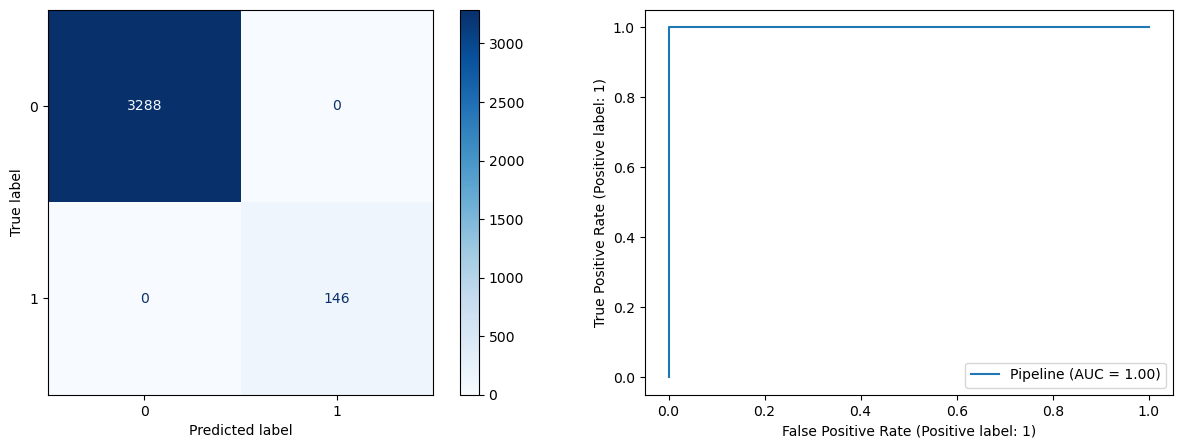

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Tuned XGBoost Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1410
           1       0.10      0.02      0.03        63

    accuracy                           0.95      1473
   macro avg       0.53      0.50      0.50      1473
weighted avg       0.92      0.95      0.93      1473

This code was taken from Coding Dojo Code Along


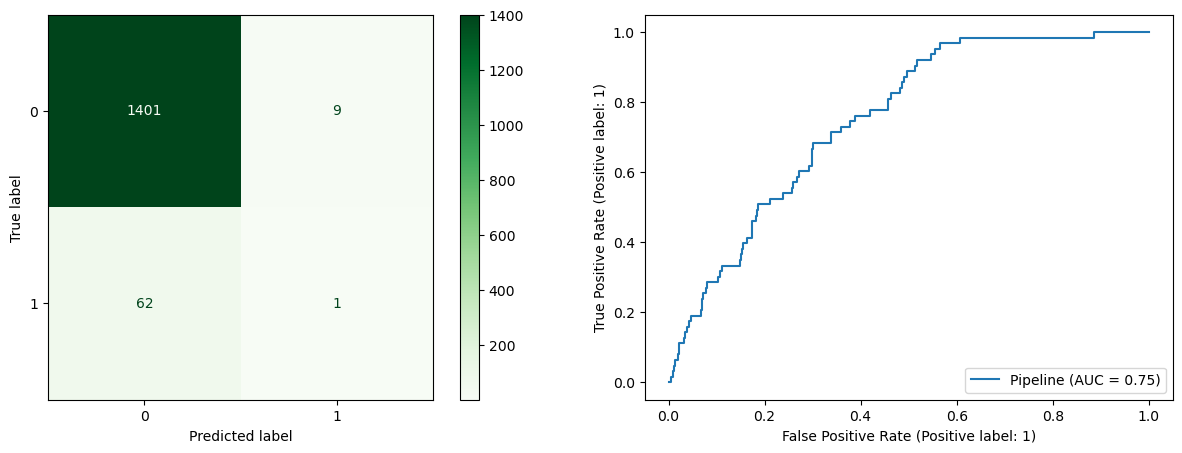

In [ ]:
probability_report_matrix(tuned_xgb_pipe, X_train, y_train, label='Tuned XGBoost Train Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Blues', thresh=.5)

probability_report_matrix(tuned_xgb_pipe, X_test, y_test, label='Tuned XGBoost Test Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Greens', thresh=.5)

### Under Sampling XGBoost

In [ ]:
under_sampler = RandomUnderSampler()
xgb = XGBClassifier(random_state=42)

under_xgb_pipe = make_sampler_pipeline(preprocessor, under_sampler, xgb)
#Fit and evaluate the model pipeline
under_xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127310>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127BB0>)])),
                ('...
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=16, num_parallel_tree=1, predictor='auto',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Under Sampling XGBoost Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.71      0.83      3288
           1       0.13      1.00      0.24       146

    accuracy                           0.72      3434
   macro avg       0.57      0.86      0.53      3434
weighted avg       0.96      0.72      0.81      3434

This code was taken from Coding Dojo Code Along


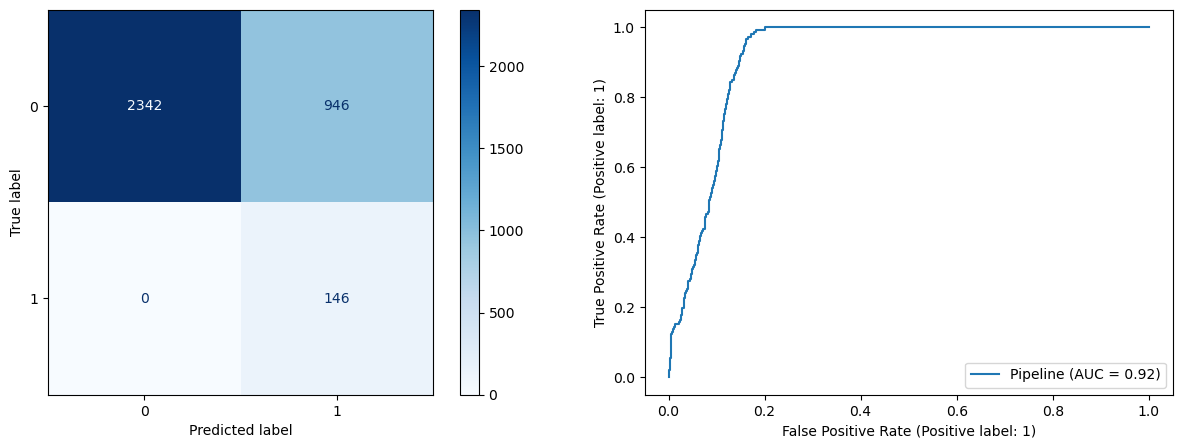

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Under Sampling XGBoost Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.69      0.81      1410
           1       0.09      0.70      0.16        63

    accuracy                           0.69      1473
   macro avg       0.54      0.69      0.48      1473
weighted avg       0.94      0.69      0.78      1473

This code was taken from Coding Dojo Code Along


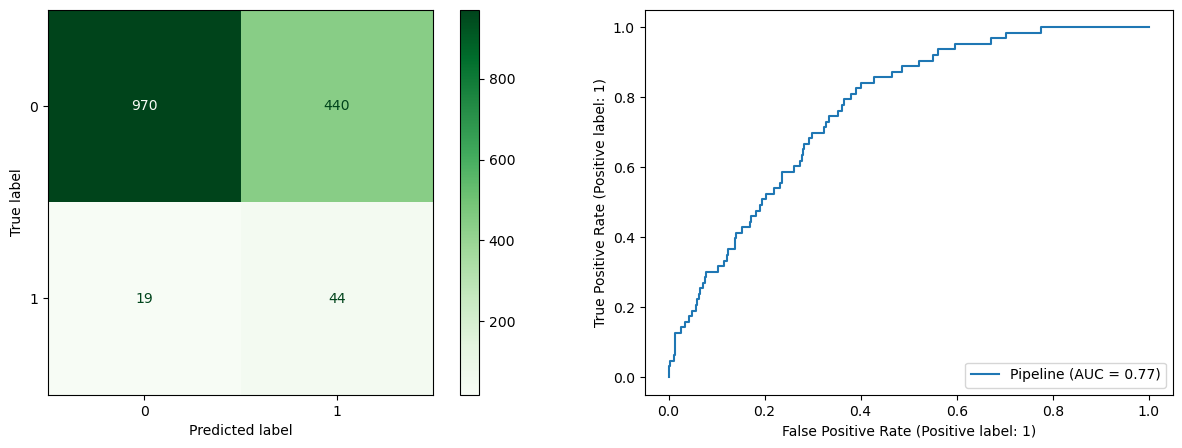

In [ ]:
probability_report_matrix(under_xgb_pipe, X_train, y_train, label='Under Sampling XGBoost Train Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Blues', thresh=.5)

probability_report_matrix(under_xgb_pipe, X_test, y_test, label='Under Sampling XGBoost Test Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Greens', thresh=.5)

### Tuned Under Sampling XGBoost

In [ ]:
under_xgb_pipe_gs = GridSearchCV(under_xgb_pipe, xgb_params, scoring='f1')
 
under_xgb_pipe_gs.fit(X_train, y_train)
print('Best XGB Parameters:')
print(under_xgb_pipe_gs.best_params_)
best_under_xgb_pipe = under_xgb_pipe_gs.best_estimator_
print(f'Accuracy of best XGB model is: {best_under_xgb_pipe.score(X_test, y_test)}')

Best XGB Parameters:
{'xgbclassifier__max_delta_step': 1, 'xgbclassifier__max_depth': 3, 'xgbclassifier__n_estimators': 30}
Accuracy of best XGB model is: 0.6985743380855397


In [ ]:
tuned_under_xgb = XGBClassifier(max_delta_step=1, max_depth=3, n_estimators=30, random_state=42, verbosity=0)

tuned_under_xgb_pipe = make_sampler_pipeline(preprocessor, under_sampler, tuned_under_xgb)
tuned_under_xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127310>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127BB0>)])),
                ('...
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=1,
                               max_depth=3, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=30,
                               n_jobs=16, num_parallel_tree=1, predictor='auto',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=0))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Tuned Under Sampling XGBoost Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.70      0.83      3288
           1       0.13      0.96      0.22       146

    accuracy                           0.71      3434
   macro avg       0.56      0.83      0.52      3434
weighted avg       0.96      0.71      0.80      3434

This code was taken from Coding Dojo Code Along


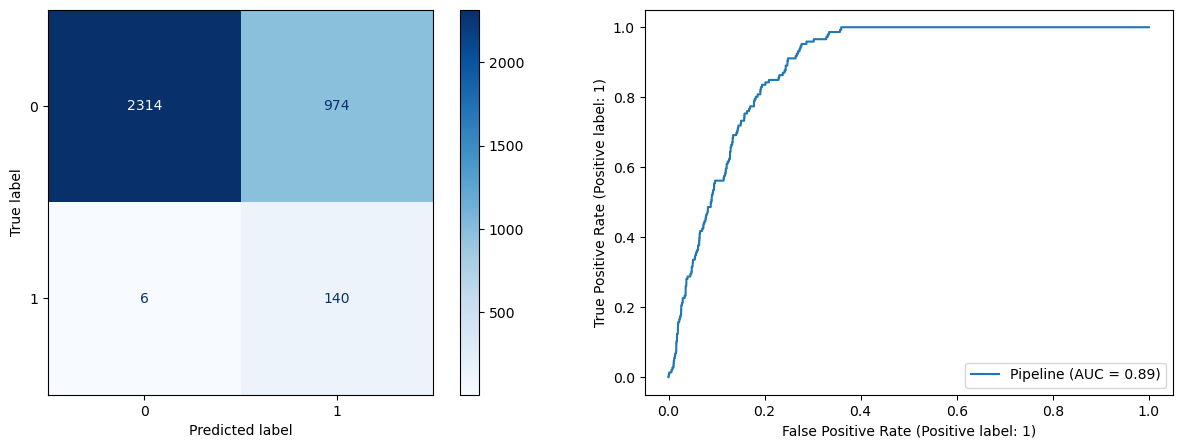

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Tuned Under Sampling XGBoost Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.68      0.80      1410
           1       0.10      0.78      0.17        63

    accuracy                           0.68      1473
   macro avg       0.54      0.73      0.49      1473
weighted avg       0.95      0.68      0.78      1473

This code was taken from Coding Dojo Code Along


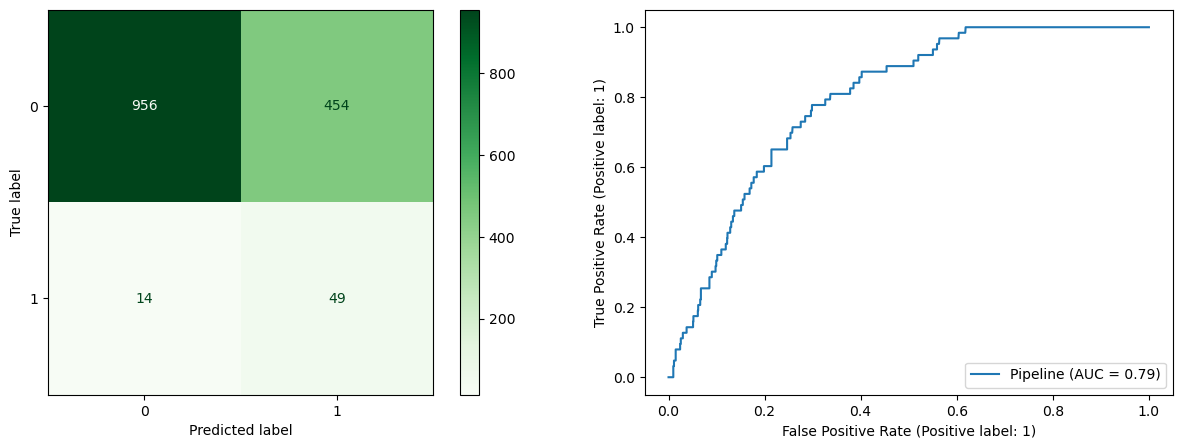

In [ ]:
probability_report_matrix(tuned_under_xgb_pipe, X_train, y_train, label='Tuned Under Sampling XGBoost Train Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Blues', thresh=.5)

probability_report_matrix(tuned_under_xgb_pipe, X_test, y_test, label='Tuned Under Sampling XGBoost Test Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Greens', thresh=.5)

## Best Model

- The best model was KNN with Under Sampling class balancing and GridSearchCV Tuning
    - I had tried to class balance because the classes are significantly unbalanced
- I will now use Feature Engineering and PCA on this model to try and get better results
- The most important aspect for this business problem is *accuracy* and *f1 score* 
    - **It is better to catch more positive results, even if that means we catch more false positives, because telling someone they're not likely to have a stroke when they in fact are more likely will be very harmful to the patient.**


## Feature Engineering

- Will bin 'bmi', 'age', and 'avg_glucose_level'
- Since the target values are classification, the model will better fit if the features are also classification

In [ ]:
df2 = df.copy()
df2.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


### Bin age

In [ ]:
df2['age'].describe()

count    4907.000000
mean       42.874082
std        22.555402
min         0.080000
25%        25.000000
50%        44.000000
75%        60.000000
max        82.000000
Name: age, dtype: float64

In [ ]:
def bin_age(age):
    if 0 <= age < 25:
        return 'young_age'
    if 25 <= age < 44:
        return 'middle_age'
    else:
        return 'old_age'

In [ ]:
df2['age'] = df2['age'].apply(bin_age)
df2.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,old_age,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Male,old_age,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,old_age,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,old_age,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,old_age,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


### Bin bmi

In [ ]:
df2['bmi'].describe()

count    4907.000000
mean       28.880558
std         7.793622
min        10.300000
25%        23.500000
50%        28.100000
75%        33.100000
max        92.000000
Name: bmi, dtype: float64

In [ ]:
def bin_bmi(bmi):
    if 10 <= bmi < 23:
        return 'underweight'
    if 23 <= bmi < 28:
        return 'normal'
    if 28 <= bmi < 33:
        return 'overweight'
    else:
        return 'obese'

In [ ]:
df2['bmi'] = df2['bmi'].apply(bin_bmi)
df2.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,old_age,0,1,Yes,Private,Urban,228.69,obese,formerly smoked,1
2,Male,old_age,0,1,Yes,Private,Rural,105.92,overweight,never smoked,1
3,Female,old_age,0,0,Yes,Private,Urban,171.23,obese,smokes,1
4,Female,old_age,1,0,Yes,Self-employed,Rural,174.12,normal,never smoked,1
5,Male,old_age,0,0,Yes,Private,Urban,186.21,overweight,formerly smoked,1


### Bin avg_glucose_level

In [ ]:
df2['avg_glucose_level'].describe()

count    4907.000000
mean      105.306293
std        44.425711
min        55.120000
25%        77.075000
50%        91.680000
75%       113.520000
max       271.740000
Name: avg_glucose_level, dtype: float64

In [ ]:
def bin_glucose(glucose):
    if 69 <= glucose < 81:
        return 'low'
    if 81 <= glucose < 104:
        return 'medium'
    else:
        return 'high'

In [ ]:
df2['avg_glucose_level'] = df2['avg_glucose_level'].apply(bin_glucose)
df2.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,old_age,0,1,Yes,Private,Urban,high,obese,formerly smoked,1
2,Male,old_age,0,1,Yes,Private,Rural,high,overweight,never smoked,1
3,Female,old_age,0,0,Yes,Private,Urban,high,obese,smokes,1
4,Female,old_age,1,0,Yes,Self-employed,Rural,high,normal,never smoked,1
5,Male,old_age,0,0,Yes,Private,Urban,high,overweight,formerly smoked,1


## PCA

In [ ]:
X2 = df2.drop(columns='stroke')
y2 = df2['stroke']

In [ ]:
X2.shape

(4907, 10)

In [ ]:
processed_df2 = preprocessor.fit_transform(X2)
processed_df2.shape

(4907, 27)

In [ ]:
processed_df2.shape[1]

27

In [ ]:
pca = PCA()
pca.fit(processed_df2)

PCA()

### Scree Plot

- To check if PCA is applicable and, if so, how many `n_components` is optimal

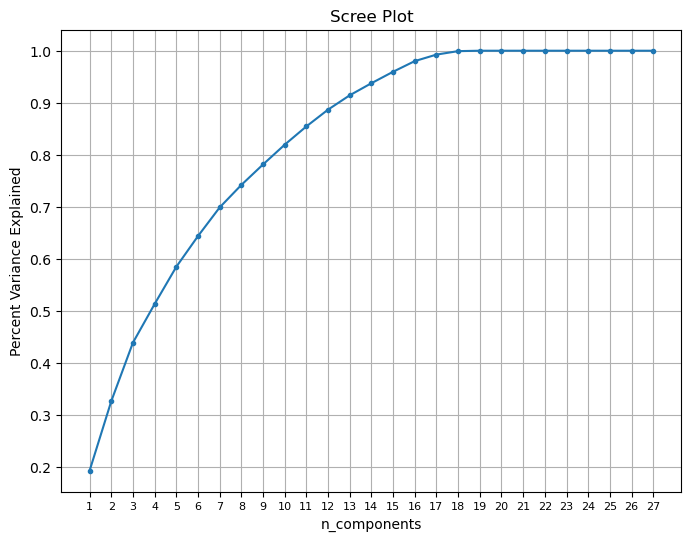

In [ ]:
# plot the cumulative sum of the percentage of explained variance for each component and those before it.

fig, ax = plt.subplots(figsize=(8, 6))

plt.plot(range(1, (processed_df2.shape[1] + 1)), pca.explained_variance_ratio_.cumsum(), marker= '.')
plt.xticks(ticks=range(1,(processed_df2.shape[1] + 1)), fontsize=8)

plt.xlabel('n_components')
plt.ylabel('Percent Variance Explained')
plt.title('Scree Plot')

plt.grid();

- From the Scree Plot, we can see that the plot isn't linear
    - Which means that at a certain point, before max n_components, we'll reach 100% variance explained
- We can also see that 100% variance explained is reached at 17 n_components, which is a reduction of 37% of n_components/features

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, stratify=y, test_size=0.3, random_state=42)
pca17 = PCA(n_components=17)

### KNN PCA

In [ ]:
knn = KNeighborsClassifier()

knn_pca_pipe = make_pipeline(preprocessor, pca17, knn)
knn_pca_pipe.fit(X2_train, y2_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127310>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127BB0>)])),
                ('pca', PCA(n_components=17)),
                ('kneighborsclassifier', KNeighborsClassifier())])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: PCA Random Forest Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3288
           1       0.70      0.05      0.09       146

    accuracy                           0.96      3434
   macro avg       0.83      0.52      0.53      3434
weighted avg       0.95      0.96      0.94      3434

This code was taken from Coding Dojo Code Along


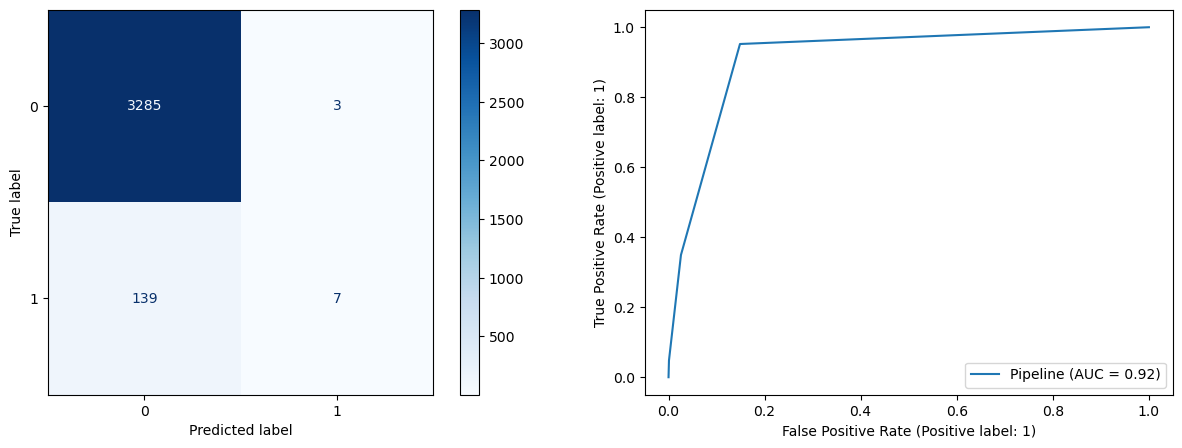

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: PCA Random Forest Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1410
           1       0.00      0.00      0.00        63

    accuracy                           0.96      1473
   macro avg       0.48      0.50      0.49      1473
weighted avg       0.92      0.96      0.94      1473

This code was taken from Coding Dojo Code Along


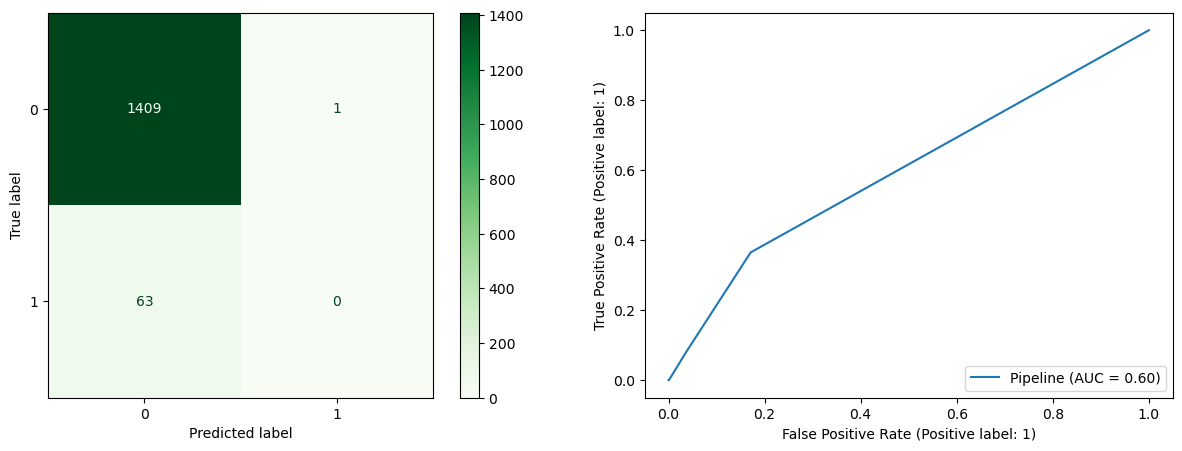

In [ ]:
probability_report_matrix(knn_pca_pipe, X2_train, y2_train, label='PCA Random Forest Train Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Blues', thresh=.5)

probability_report_matrix(knn_pca_pipe, X2_test, y2_test, label='PCA Random Forest Test Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Greens', thresh=.5)

### Tuned KNN PCA

In [ ]:
knn_params = {'kneighborsclassifier__n_neighbors': range(1,10),
              'kneighborsclassifier__p': range(1,5),
              'kneighborsclassifier__weights': ['distance','uniform']}

In [ ]:
knn_pca_pipe_gs = GridSearchCV(knn_pca_pipe, knn_params, scoring='f1')
 
knn_pca_pipe_gs.fit(X2_train, y2_train)
print('Best Random Forest PCA Parameters:')
print(knn_pca_pipe_gs.best_params_)
best_knn_pca_pipe = knn_pca_pipe_gs.best_estimator_
print(f'Accuracy of best Random Forest model is: {best_knn_pca_pipe.score(X2_test, y2_test)}')

Best Random Forest PCA Parameters:
{'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__p': 2, 'kneighborsclassifier__weights': 'uniform'}
Accuracy of best Random Forest model is: 0.9205702647657841


In [ ]:
tuned_knn_pca = KNeighborsClassifier(n_neighbors=1, p=2, weights='uniform')

tuned_knn_pca_pipe = make_pipeline(preprocessor, pca17, tuned_knn_pca)
tuned_knn_pca_pipe.fit(X2_train, y2_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127310>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127BB0>)])),
                ('pca', PCA(n_components=17)),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=1))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Tuned PCA KNN Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3288
           1       0.60      0.53      0.56       146

    accuracy                           0.97      3434
   macro avg       0.79      0.76      0.77      3434
weighted avg       0.96      0.97      0.96      3434

This code was taken from Coding Dojo Code Along


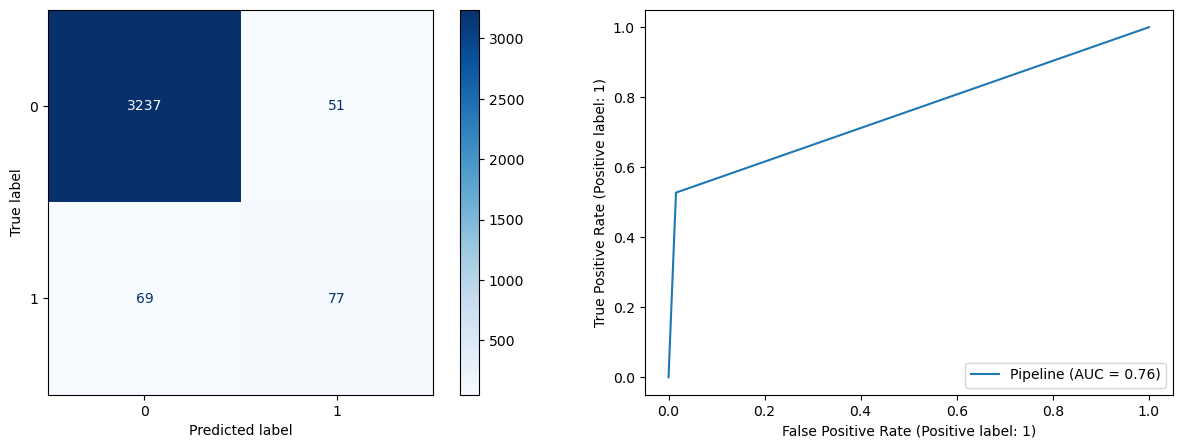

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Tuned PCA KNN Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1410
           1       0.16      0.16      0.16        63

    accuracy                           0.93      1473
   macro avg       0.56      0.56      0.56      1473
weighted avg       0.93      0.93      0.93      1473

This code was taken from Coding Dojo Code Along


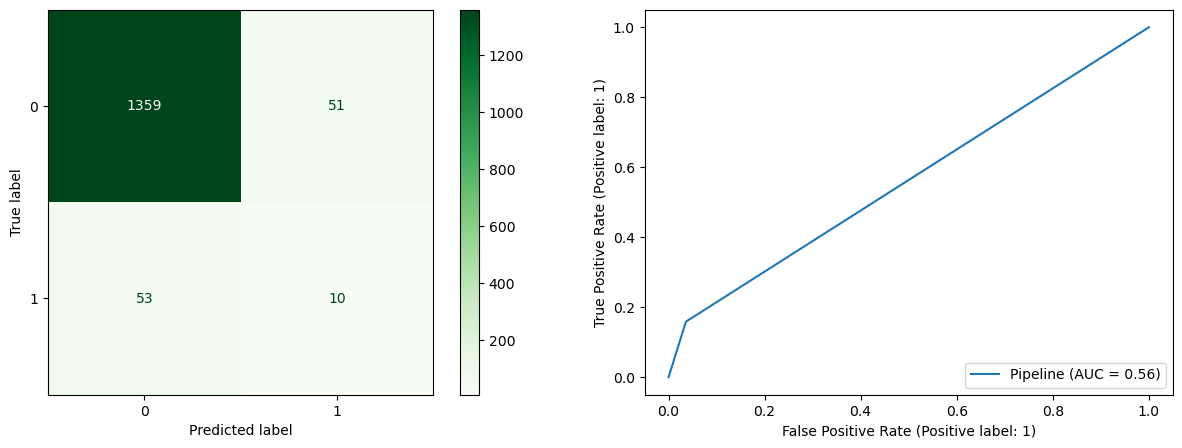

In [ ]:
probability_report_matrix(tuned_knn_pca_pipe, X2_train, y2_train, label='Tuned PCA KNN Train Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Blues', thresh=.5)

probability_report_matrix(tuned_knn_pca_pipe, X2_test, y2_test, label='Tuned PCA KNN Test Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Greens', thresh=.5)

### Under Sampling Tuned KNN PCA

In [ ]:
under_sampler = RandomUnderSampler()
knn = KNeighborsClassifier()

under_knn_pca_pipe = make_sampler_pipeline(preprocessor, under_sampler, pca, knn)
#Fit and evaluate the model pipeline
under_knn_pca_pipe.fit(X2_train, y2_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127310>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127BB0>)])),
                ('randomundersampler', RandomUnderSampler()), ('pca', PCA()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [ ]:
under_knn_pca_pipe_gs = GridSearchCV(under_knn_pca_pipe, knn_params, scoring='f1')
 
under_knn_pca_pipe_gs.fit(X2_train, y2_train)
print('Best KNN Parameters:')
print(under_knn_pca_pipe_gs.best_params_)
best_under_knn_pca_pipe = under_knn_pca_pipe_gs.best_estimator_
print(f'Accuracy of best KNN model is: {best_under_knn_pca_pipe.score(X2_test, y2_test)}')

Best KNN Parameters:
{'kneighborsclassifier__n_neighbors': 9, 'kneighborsclassifier__p': 2, 'kneighborsclassifier__weights': 'distance'}
Accuracy of best KNN model is: 0.6578411405295316


In [ ]:
tuned_under_knn_pca = KNeighborsClassifier(n_neighbors=9, p=2, weights='distance')

tuned_under_knn_pca_pipe = make_sampler_pipeline(preprocessor, under_sampler, pca, tuned_under_knn_pca)
tuned_under_knn_pca_pipe.fit(X2_train, y2_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127310>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028F0A127BB0>)])),
                ('randomundersampler', RandomUnderSampler()), ('pca', PCA()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=9, weights='distance'))])

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Tuned Under Sampling PCA KNN Train Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.65      0.79      3288
           1       0.11      0.94      0.19       146

    accuracy                           0.66      3434
   macro avg       0.55      0.79      0.49      3434
weighted avg       0.96      0.66      0.76      3434

This code was taken from Coding Dojo Code Along


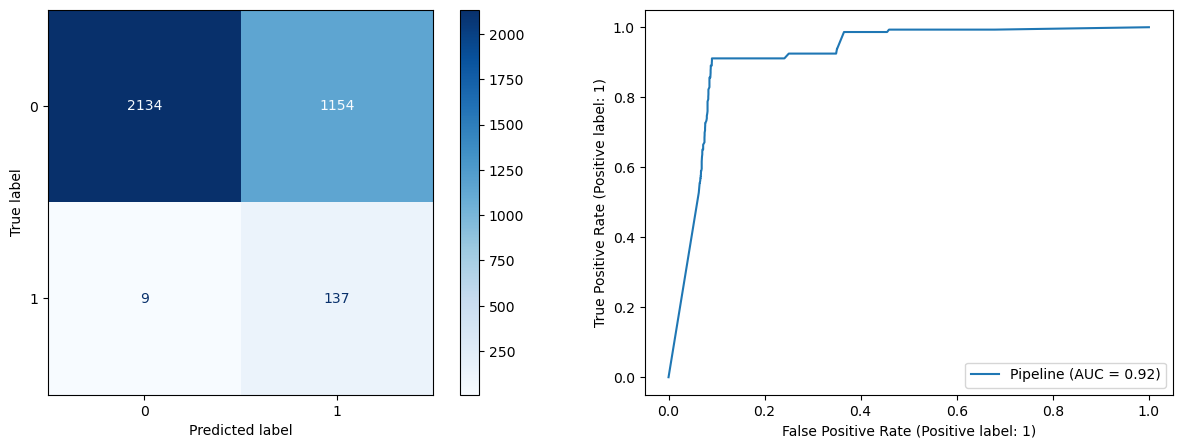

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Tuned Under Sampling PCA KNN Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.61      0.75      1410
           1       0.07      0.63      0.12        63

    accuracy                           0.62      1473
   macro avg       0.52      0.62      0.44      1473
weighted avg       0.94      0.62      0.73      1473

This code was taken from Coding Dojo Code Along


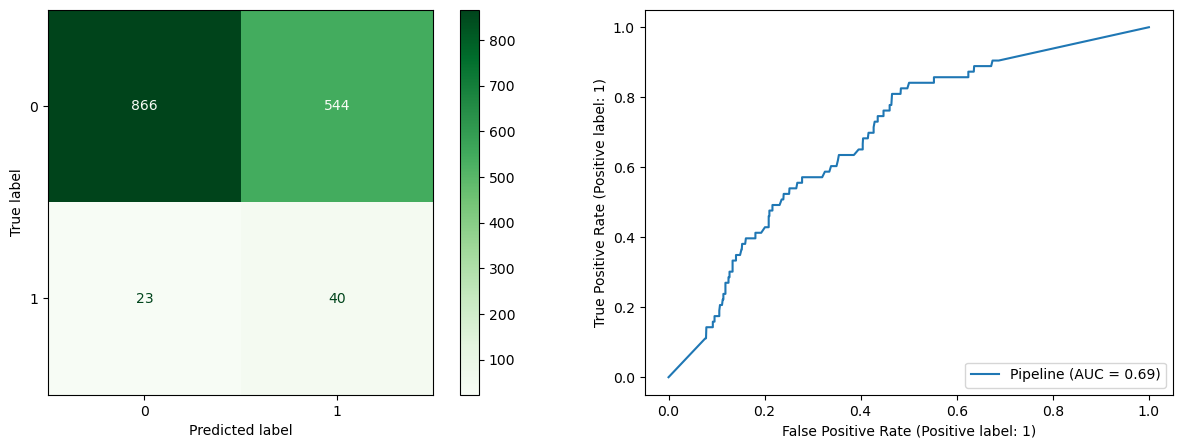

In [ ]:
probability_report_matrix(tuned_under_knn_pca_pipe, X2_train, y2_train, label='Tuned Under Sampling PCA KNN Train Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Blues', thresh=.5)

probability_report_matrix(tuned_under_knn_pca_pipe, X2_test, y2_test, label='Tuned Under Sampling PCA KNN Test Data', 
                             figsize=(15,5), normalize= None,
                             cmap='Greens', thresh=.5)

# Best Overall Model Evaluation

- The best model overall is Tuned Under Sampling KNN
    - This model maintained the higher `f1` and `accuracy` scores indicating that it is making correct predictions at a rate of 76% while at the same time keeping the False Negatives at a 38% rate.
    
- Recall is at 62% for the Positive Class
    - Precision is at 11%, which means that there are a significant amount of False Positives, but recall is more important in this instance since falsely categorizing someone as 'not likely' to get a stroke is very harmful to the patient
- This is the model I would recommend

# Limitations

- Though PCA has it's uses, in this instance, it appears that it was not suited for our business problem
    - Even though accuracy was the highest for the Tuned KNN PCA model, the *recall* score was at 16% which is substantially low and won't help us correctly predict True Positive cases